Global settings and import

In [ ]:


from matplotlib import pyplot as plt

outputs=['RESULT_InclinationBeltDirection__deg_',
       'RESULT_Inclination90ToBeltDirection__deg_']


Columns after low variance filter and domain knowledge

In [ ]:
with open("data\columns_domain.txt", "r") as file:
    columns = file.read().strip().split(",")

Import, NAN filter

In [ ]:
from utils import load_raw
importer=load_raw.DataFrameImporter()
importer.load("Data","data/Data Thesis.csv")
#importer.NOK_Cleaning("100k",True)
importer.NAN_Cleaning("Data")
df = importer.get_dataframe("Data")
df.head()





Outliers filter

In [ ]:
lower_tol = -0.1
upper_tol = 0.9
import numpy as np
inclination=df[outputs[0]].values

# Create color mask
colors = np.where((inclination < lower_tol) | (inclination > upper_tol), 'red', 'blue')

# Create the plot
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
axs[0].scatter(range(len(inclination)), inclination, c=colors, s=1, alpha=0.6, linewidths=0)

# Add tolerance lines
axs[0].axhline(lower_tol, color='gray', linestyle='--', linewidth=1, label='Tolerance limits')
axs[0].axhline(upper_tol, color='gray', linestyle='--', linewidth=1)

# Labels and title
axs[0].set_title("Inclination to Belt Direction")
axs[0].set_xlabel("Observation Index")
axs[0].set_ylabel("Inclination [°]")
axs[0].legend(loc="upper right")
axs[0].set_ylim(-0.7,1.6)

# Make it tight and readable
axs[0].grid(True, linestyle=':', linewidth=0.5)



lower_tol = -0.7
upper_tol = 0.1
import numpy as np
inclination=df[outputs[1]].values

# Create color mask
colors = np.where((inclination < lower_tol) | (inclination > upper_tol), 'red', 'blue')

# Create the plot

axs[1].scatter(range(len(inclination)), inclination, c=colors, s=1, alpha=0.6, linewidths=0)

# Add tolerance lines
axs[1].axhline(lower_tol, color='gray', linestyle='--', linewidth=1, label='Tolerance limits')
axs[1].axhline(upper_tol, color='gray', linestyle='--', linewidth=1)

# Labels and title
axs[1].set_title("Inclination 90 to Belt Direction")
axs[1].set_xlabel("Observation Index")
axs[1].set_ylabel("Inclination [°]")
axs[1].legend(loc="upper right")
axs[1].set_ylim(-1.5,1)
# Make it tight and readable
axs[1].grid(True, linestyle=':', linewidth=0.5)
plt.tight_layout()

# Show or save the figure
plt.show()

In [ ]:
from preprocess.outlier_filter import filter
df_filtered=filter(df,outputs)
inclination_toBD_original=df_filtered[outputs[0]]


Comparison of original and filtered data

In [ ]:
plt.scatter(range(len(df[outputs[0]])),df[outputs[0]].values,label="Original",alpha=0.6,linewidths=0,color='red')
plt.scatter(range(len(df_filtered[outputs[0]])),df_filtered[outputs[0]].values, label="Filtered",alpha=0.6,linewidths=0,color='blue')
plt.title("Outlier filter BD")
plt.legend()
plt.show()
plt.scatter(range(len(df[outputs[1]])),df[outputs[1]].values,label="Original",alpha=0.6,linewidths=0,color='red')
plt.scatter(range(len(df_filtered[outputs[1]])),df_filtered[outputs[1]].values, label="Filtered",alpha=0.6,linewidths=0,color='blue')
plt.title("Outlier filter 90 to BD")
plt.legend()
plt.show()

EDA

In [ ]:
from ydata_profiling import ProfileReport
import sweetviz as sv
profile = ProfileReport(df_filtered, title="Ydata Profiling Report")
profile.to_file("eda_report\ydata_report_0225.html")
report = sv.analyze(df_filtered, target_feat=outputs[0])
report.show_html('eda_report\sweetviz_report_BD_0225.html')


In [ ]:
import dtale
import dtale.global_state as global_state
global_state.set_chart_settings({'scatter_points': 200000, '3d_points': 40000})
dtale.show(df_filtered)

Normalization and transformation

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler().fit(inclination_toBD_original.values.reshape(-1, 1))

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(inclination_toBD_original.values.reshape(-1, 1))


In [ ]:
inclination_toBD_scaled=scaler.transform(inclination_toBD_original.values.reshape(-1, 1)).flatten()


StatTest

Skewness: 0.008491990456606013
Shapiro-Wilk Test Statistic:=0.9971, p-value=0.0000
Data is not normally distributed
Kolmogorov-Smirnov Test: Statistic=0.5968, p-value=0.0000
Data is NOT normal (Reject H0)


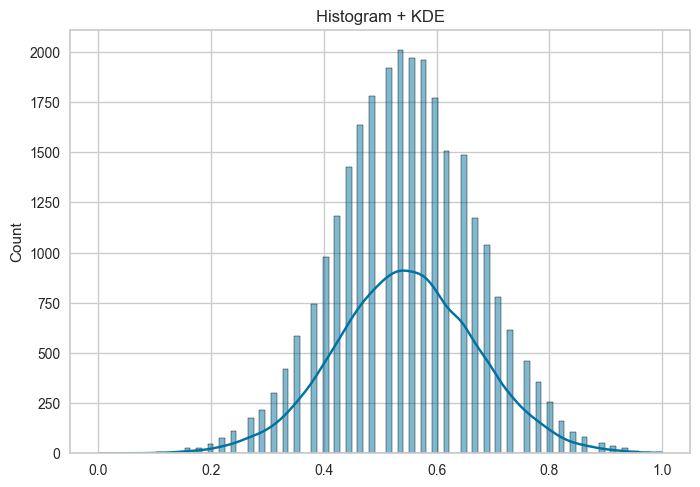

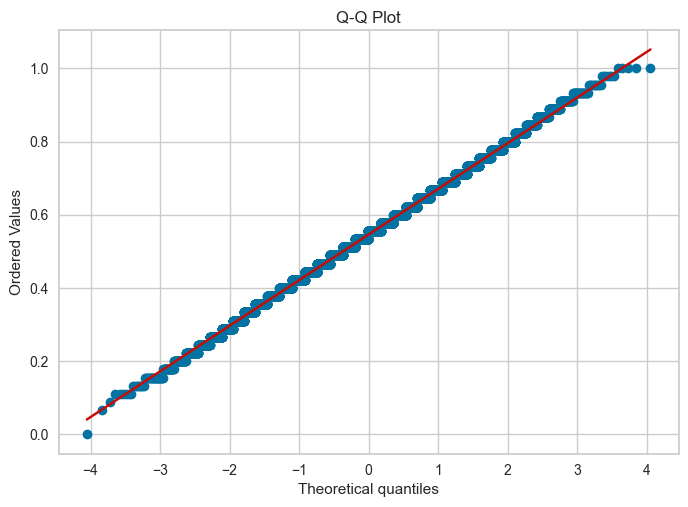

ADF Statistic: -7.428448191198322
p-value: 6.455102115477966e-11
Used Lags: 47
Number of Observations: 27468

Interpretation:
The p-value is 0.0000, which is less than 0.05.
This means the series is likely stationary.


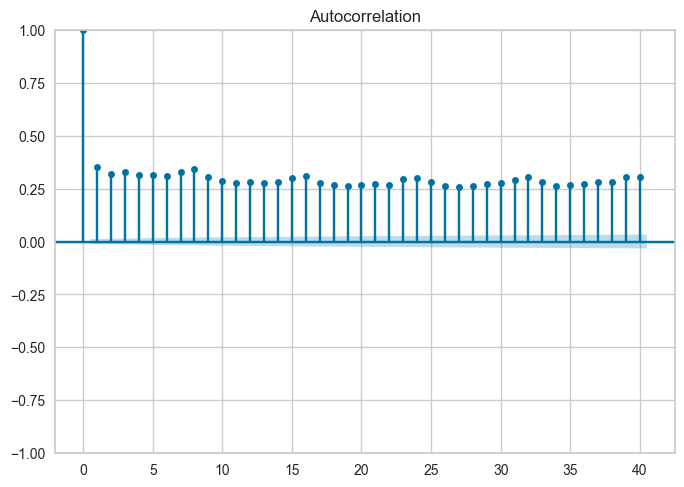

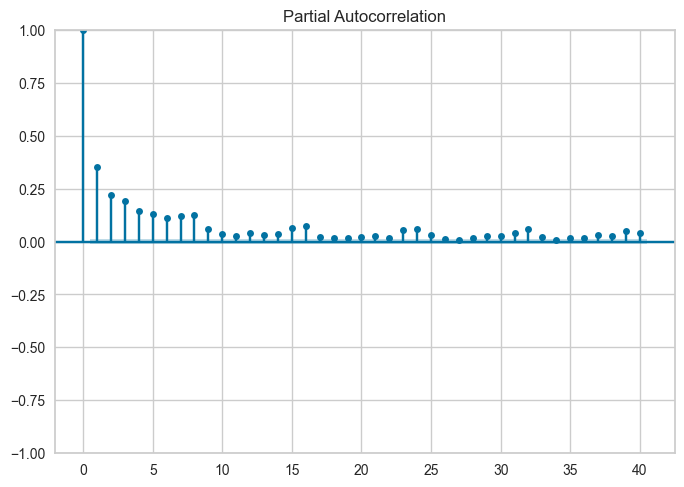

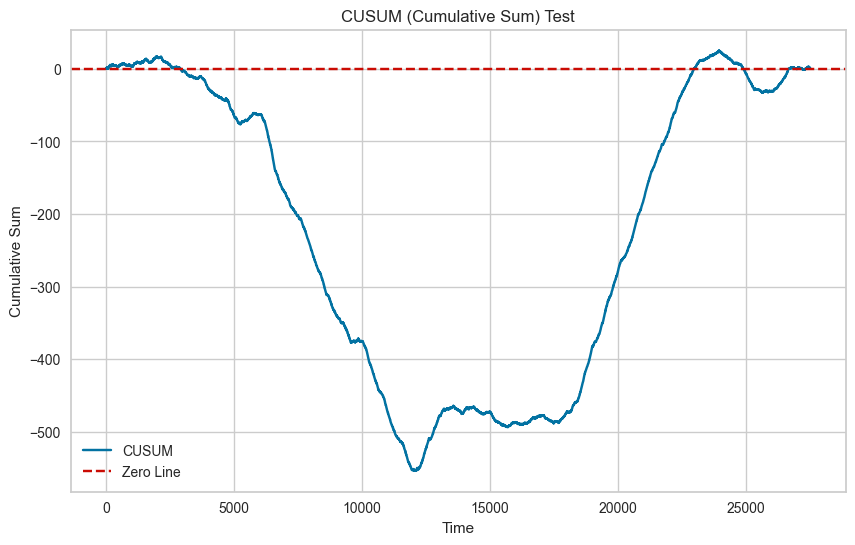

In [49]:
from evaluation import statests
import importlib
importlib.reload(statests)
statests.test_autoregression(inclination_toBD_scaled)
#statests.breakpoints(inclination_toBD_original_scaled)


In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.kdeplot(inclination_toBD_original, label="Original", fill=True, alpha=0.4)
sns.kdeplot(inclination_toBD_scaled, label="Scaled", fill=True, alpha=0.4)
#plt.hist(inclination_toBD_original,bins=46,alpha=0.5,label="Original")
#plt.hist(inclination_toBD_original_scaled,bins=46,alpha=0.5, label="Scaled")
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Inclination BD Distributions')
plt.legend()
plt.show()

In [ ]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
inclination_toBD_original_scaled_transformed_pt=pt.fit_transform(inclination_toBD_scaled.reshape(-1,1)).flatten()



Smoothing

In [52]:

from preprocess import smoothing
import pandas as pd


#methods=['MA', 'Gaussian', 'Wavelet', 'RTS']
datasmoothing = smoothing.DataSmoothing(inclination_toBD_original.values, methods=['RTS','Gaussian'], max_lag=50)
smoothed=datasmoothing.get_smoothed_data()



Smoothing tests

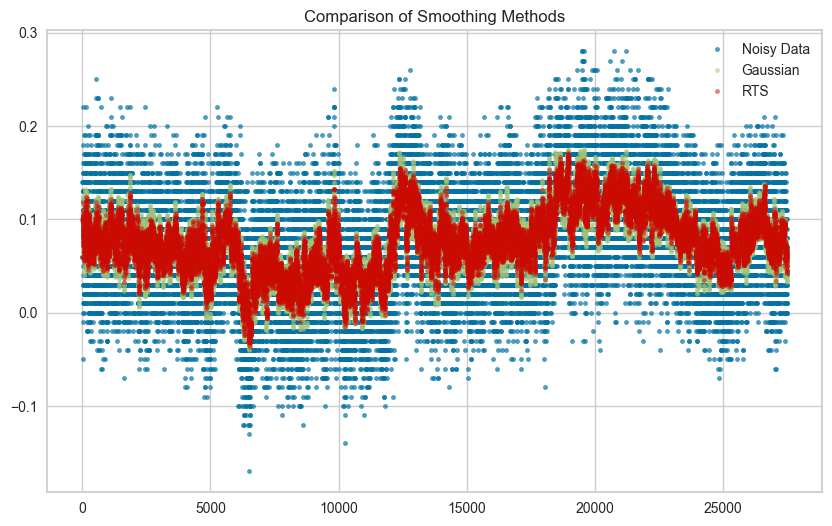

                            Gaussian       RTS
MSE                         0.001741  0.001879
Autocorrelation (Noisy)     0.352951  0.352951
Autocorrelation (Smoothed)  0.994721  0.990298
Best Lag (Noisy)            1.000000  1.000000
Best Lag (Smoothed)         1.000000  1.000000
Standard Deviation Ratio    0.623431  0.584277
Variance Ratio              0.388666  0.341379
Time                        0.005329  1.867625


In [53]:
denoised_data_test = pd.DataFrame(datasmoothing.compare_smoothing_methods())
print(denoised_data_test)

In [ ]:

inclination_toBD_sc_tr_sm=smoothed['Noisy Data']
#statests.test_autoregression(inclination_toBD_sc_tr_sm)

In [ ]:
inclination_toBD_sc_GA=smoothed['Gaussian Filter']
#statests.test_autoregression(inclination_toBD_sc_tr_sm)

Skewness: 0.0454991261594229
Shapiro-Wilk Test Statistic:=0.9969, p-value=0.0000
Data is not normally distributed
Kolmogorov-Smirnov Test: Statistic=0.4921, p-value=0.0000
Data is NOT normal (Reject H0)


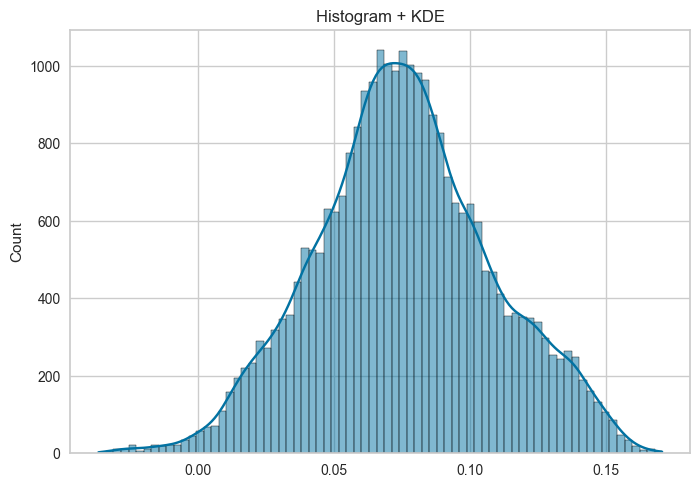

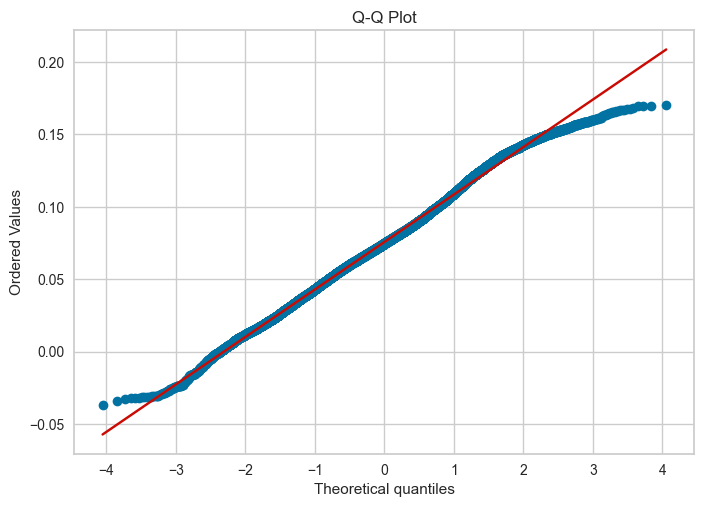

ADF Statistic: -6.707268555884969
p-value: 3.75750484548714e-09
Used Lags: 45
Number of Observations: 27470

Interpretation:
The p-value is 0.0000, which is less than 0.05.
This means the series is likely stationary.


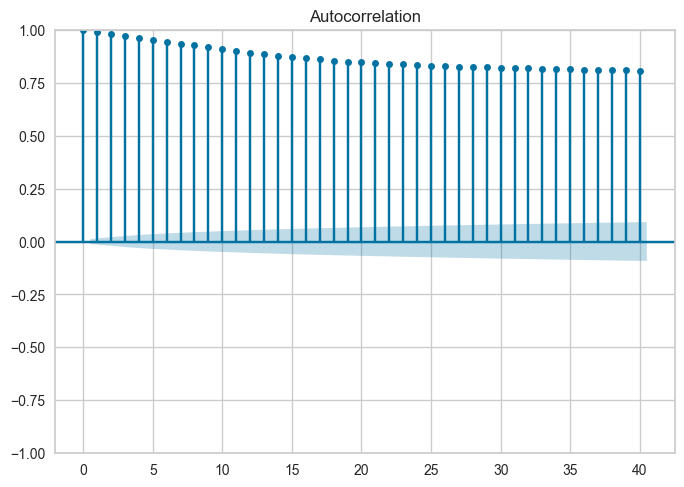

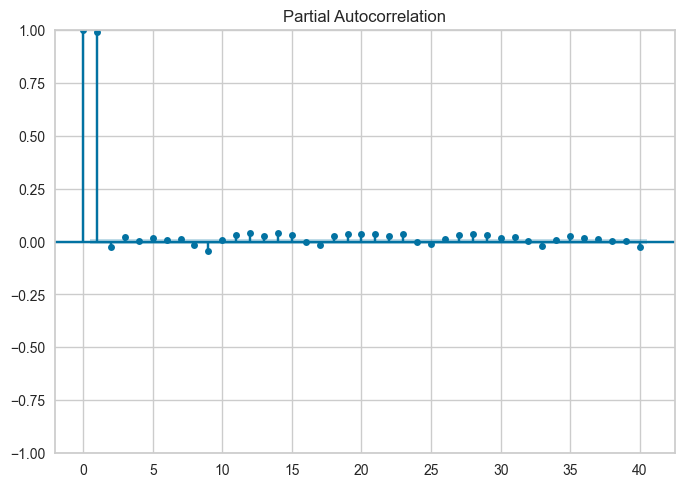

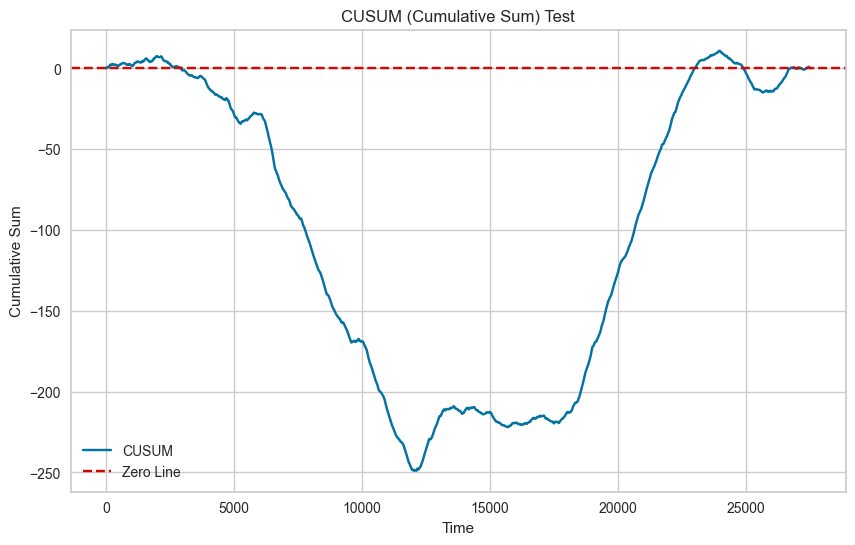

In [50]:
inclination_toBD_sc_RTS=smoothed['RTS Smoothing']
statests.test_autoregression(inclination_toBD_sc_RTS)


In [61]:
import joblib

# Save any variable (model, scaler, numpy array, dict, etc.)
#joblib.dump(inclination_toBD_sc_GA, 'tmp/output1_smoothed_gaus.pkl')
#joblib.dump(inclination_toBD_sc_RTS, 'tmp/output1_smoothed_RTS.pkl')
joblib.dump(inclination_toBD_original.values, 'tmp/output1_or.pkl')




['tmp/output1_or.pkl']

Regression

In [58]:
from regression import regression_pycaret as rpc
import importlib
importlib.reload(rpc)
regression=rpc.RegressionPyCaret(inclination_toBD_original.values)
regression.create_lagged_features()
regression.setup_and_train_models(['lr', 'ridge', 'lightgbm']) #['lr', 'ridge', 'lightgbm', 'rf']
regression_results=regression.predict()
regression_results=pd.DataFrame(regression_results)

Splitting data before training models...


,Description,Value
0,Session id,123
1,Target,target
2,Target type,Regression
3,Original data shape,"(21917, 101)"
4,Transformed data shape,"(21917, 101)"
5,Transformed train set shape,"(16438, 101)"
6,Transformed test set shape,"(5479, 101)"
7,Numeric features,100


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,0.0398,0.0025,0.0496,0.0712,0.0401,1.0187,0.0480
lr,Linear Regression,0.0399,0.0025,0.0496,0.0708,0.0402,1.0187,0.0710
lightgbm,Light Gradient Boosting Machine,0.0405,0.0026,0.0504,0.0431,0.0408,1.0271,0.6750


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.0354,0.0020,0.0446,0.1419,0.0389,0.7924


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.0354,0.0020,0.0446,0.1415,0.0389,0.7926


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0358,0.0020,0.0451,0.1227,0.0394,0.7951


In [ ]:
plt.plot(inclination_toBD_original[-5480:].values)
plt.plot(scaler.inverse_transform(inclination_toBD_sc_RTS[-5480:].reshape(-1,1)).flatten())
plt.plot(scaler.inverse_transform(y_true.values.reshape(-1,1)).flatten())


Linear regression
  Metric       Value
0    MSE    0.001987
1    MAE    0.035424
2   RMSE    0.044578
3     R2    0.141862
4   MAPE         inf
5  SMAPE   49.933818
6    SAE  194.123947


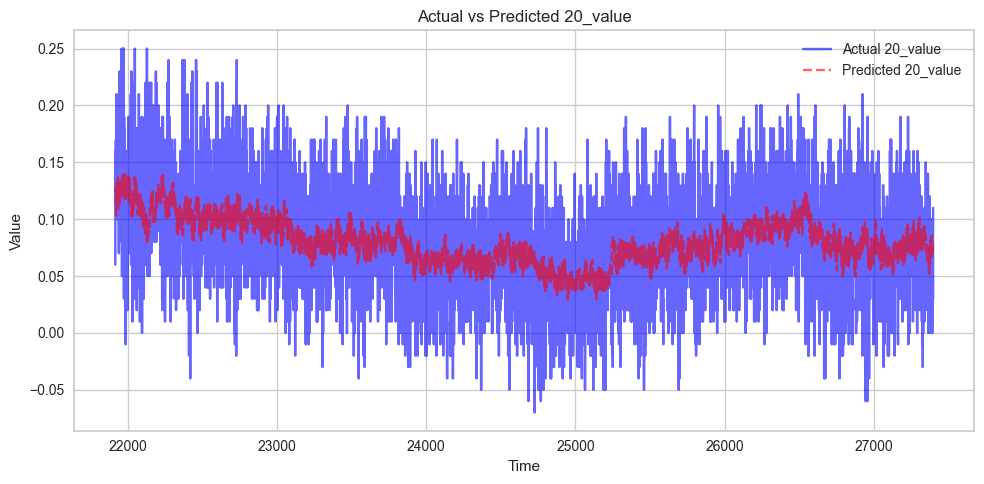

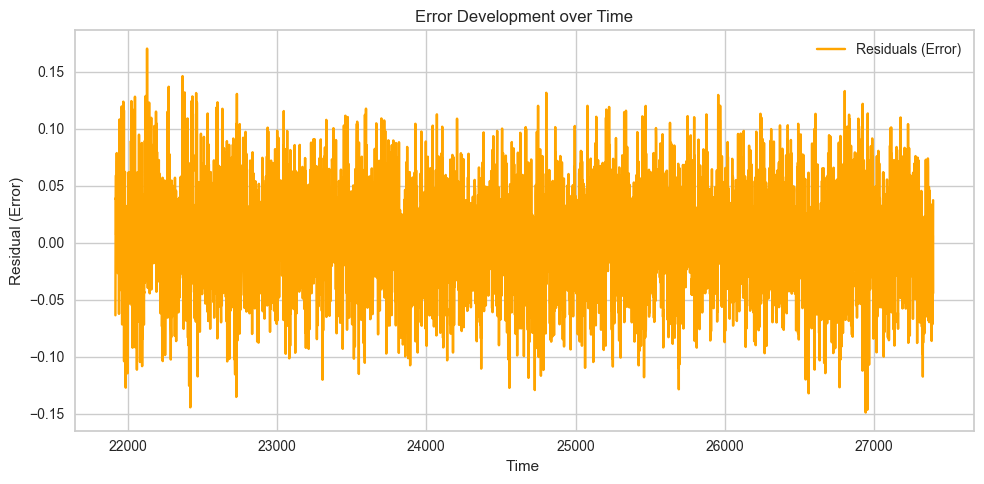

Ridge regression
  Metric       Value
0    MSE    0.001988
1    MAE    0.035433
2   RMSE    0.044588
3     R2    0.141471
4   MAPE         inf
5  SMAPE   49.946615
6    SAE  194.171783


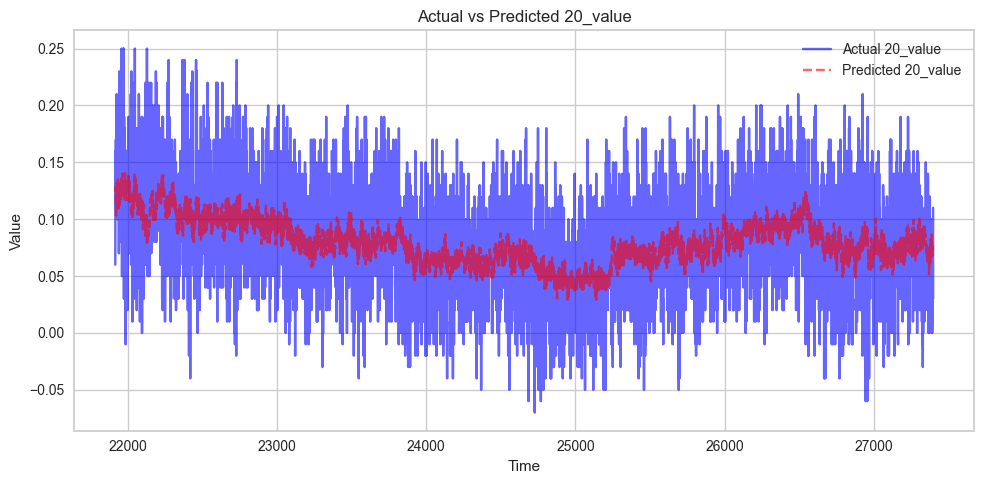

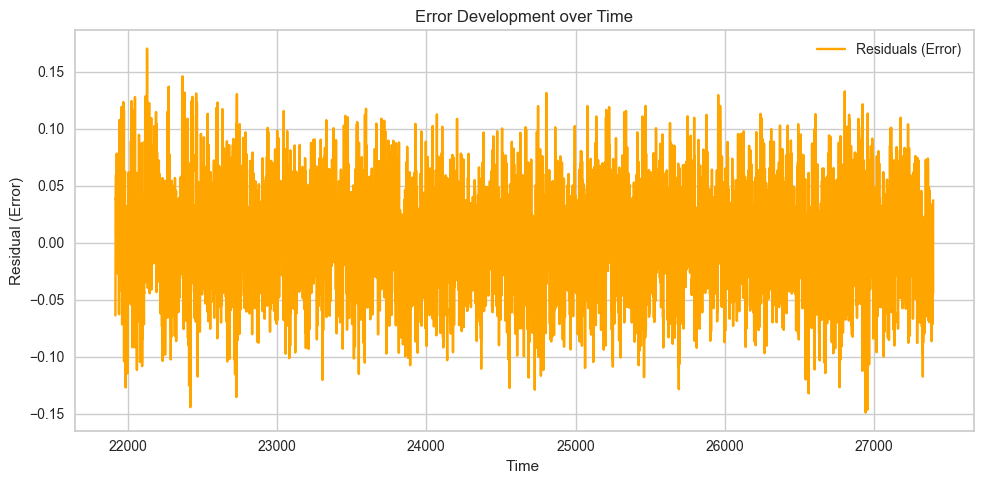

Random Forest regression
  Metric       Value
0    MSE    0.002032
1    MAE    0.035801
2   RMSE    0.045073
3     R2    0.122696
4   MAPE         inf
5  SMAPE   50.400881
6    SAE  196.186827


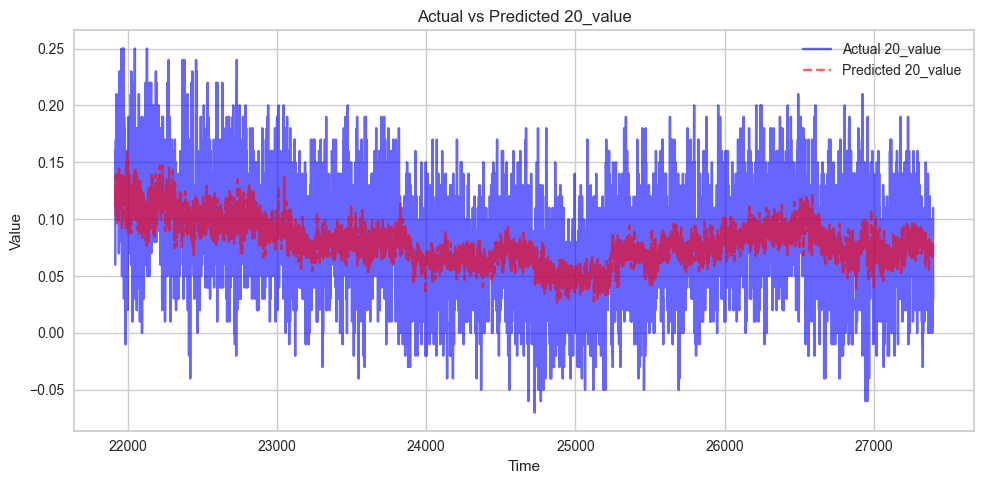

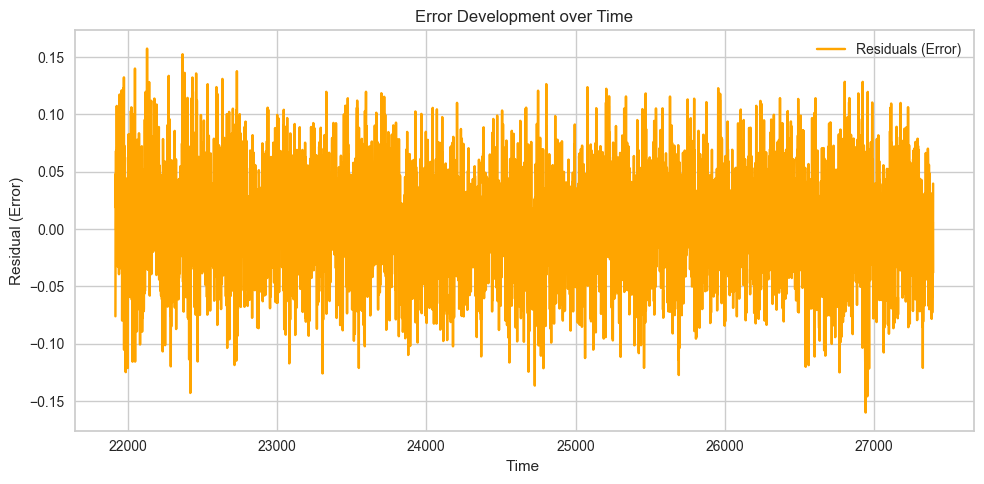

In [59]:
from evaluation import evalresu as er
rr_pred=regression_results[regression_results.columns[0]]
lr_pred=regression_results[regression_results.columns[1]]
lgmb_pred=regression_results[regression_results.columns[2]]
#lgmb_pred=regression_results[regression_results.columns[3]]
y_true=regression_results[regression_results.columns[3]]
print('Linear regression')
er.evaluate_n_values(y_true,rr_pred,20)
print('Ridge regression')

er.evaluate_n_values(y_true,lr_pred,20)
print('Random Forest regression')

#er.evaluate_n_values(y_true,rf_pred,20)
#print('Lightgmb regression')

er.evaluate_n_values(y_true,lgmb_pred,20)

from autoregression.utils_ar import prepare_direct_lstm_data 


n_past_values=100
n_future_values=20
input_shape=(n_past_values,1)

X_train_dir, y_train_dir,X_val_dir,y_val_dir,X_test_or,y_test_or = prepare_direct_lstm_data(inclination_toBD_original,n_past_values,n_future_values)
X_train_dir, y_train_dir,X_val_dir,y_val_dir,X_test_rts,y_test_rts = prepare_direct_lstm_data(inclination_toBD_sc_RTS,n_past_values,n_future_values)




  Metric       Value
0    MSE    0.001975
1    MAE    0.035379
2   RMSE    0.044440
3     R2    0.128357
4   MAPE         inf
5  SMAPE   50.167947
6    SAE  190.517083


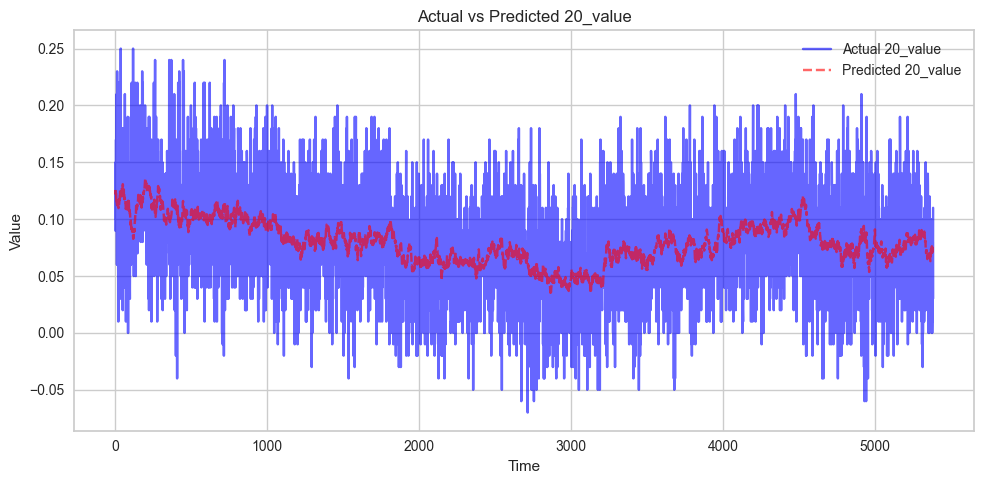

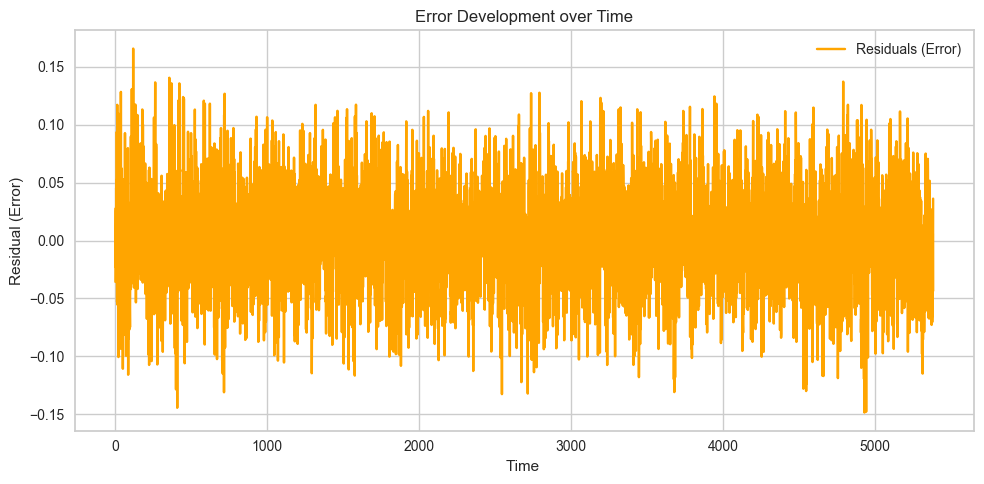

,Metric,Value
0,MSE,0.001975
1,MAE,0.035379
2,RMSE,0.044440
3,R2,0.128357
4,MAPE,inf
5,SMAPE,50.167947
6,SAE,190.517083


In [57]:
trained_model_reg=regression.get_trained_models()
from autoregression.utils_ar import prepare_direct_lstm_data 


n_past_values=100
n_future_values=20
input_shape=(n_past_values,1)

X_train_dir, y_train_dir,X_val_dir,y_val_dir,X_test_or,y_test_or = prepare_direct_lstm_data(inclination_toBD_original,n_past_values,n_future_values)
X_train_dir, y_train_dir,X_val_dir,y_val_dir,X_test_rts,y_test_rts = prepare_direct_lstm_data(inclination_toBD_sc_RTS,n_past_values,n_future_values)
y_pred=trained_model_reg[0].predict(X_test_rts.squeeze(axis=-1)).reshape(-1,1).flatten()
y_true=y_test_or[:,-1]
er.evaluate_n_values(y_true,y_pred,20)

In [ ]:
from pycaret.regression import *
importance = pd.Series(trained_model_reg[2].feature_importances_, index=get_config('X_train').columns)
importance.sort_values(ascending=False, inplace=True)
print(importance)
plot_model(trained_model_reg[2],plot='feature')


In [ ]:
from autoregression.models.DirMultiLSTM import build_direct_lstm_model
model_dir=build_direct_lstm_model()
model_dir.summary()


Auto-regression

general setting, import 

In [ ]:
from autoregression.models.DirMultiLSTM import build_direct_lstm_model
from autoregression.models.RecurLSTM import build_recursive_lstm
from autoregression.utils_ar import prepare_direct_lstm_data 
from autoregression.utils_ar import prepare_recursive_lstm_data 
from autoregression.utils_ar import n_from_recursive
from evaluation import evalresu as er
import importlib
from tensorflow.keras.models import load_model
import utils.paths
importlib.reload(utils.paths)
from utils.paths import LSTM_MODELS_DIR


n_past_values=100
n_future_values=20
import shutil
print(shutil.which("dot"))

#data=inclination_toBD_sc_tr_sm

Models 

Model: "Direct_LSTM_Model_simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,590 (213.25 KB)

 Trainable params: 18,196 (71.08 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 36,394 (142.17 KB)

Model: "Refinement_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ refinement_input (InputLayer)   │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ refinement_lstm (LSTM)          │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ refined_20th_output (Dense)     │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,157 (51.40 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,772 (34.27 KB)

Model: "Seq2Seq_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_lstm (LSTM)             │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_lstm (LSTM)             │ (None, 20, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_output         │ (None, 20, 1)          │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,117 (148.90 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,412 (99.27 KB)

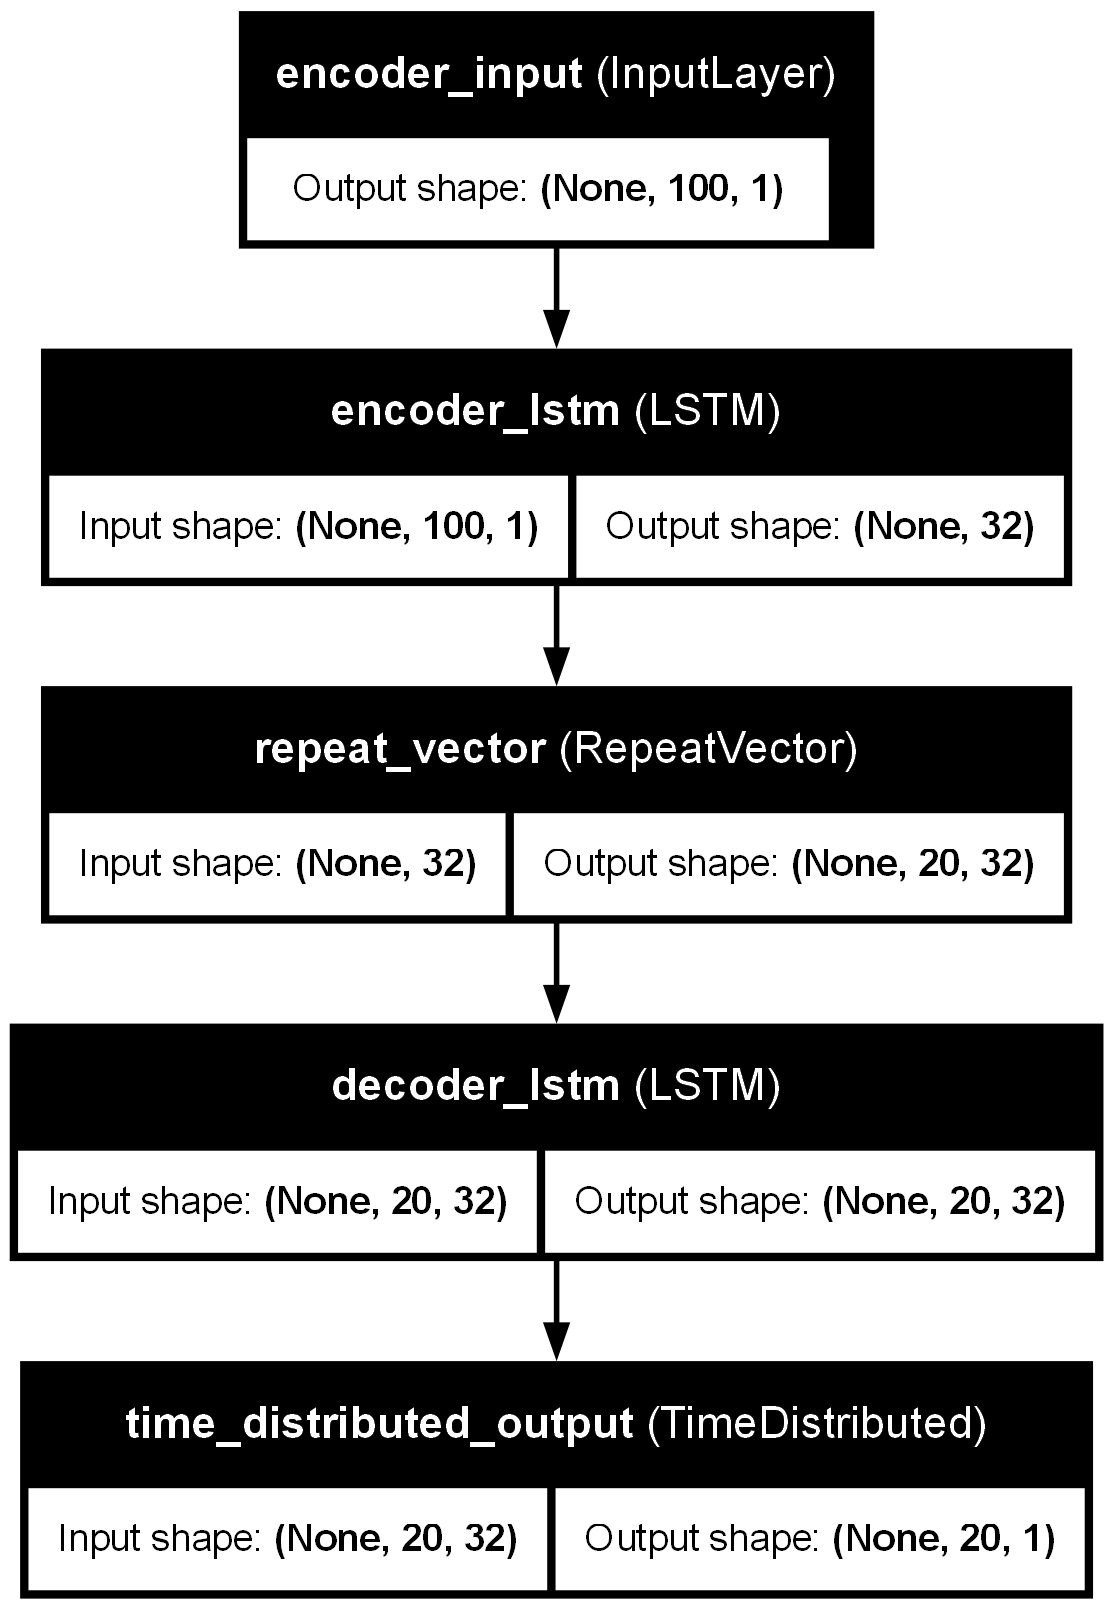

In [64]:
import mlflow.keras
from utils.paths import ML_FLOW_DIR
from tensorflow.keras.utils import plot_model


mlflow.set_tracking_uri(ML_FLOW_DIR)

direct_simple_model = mlflow.keras.load_model(f"models:/Direct_LSTM_Model_simple/1")
direct_simple_model.summary()
# plot and save to file
plot_model(direct_simple_model, to_file="export/png/model_dir_simple_architecture.png", show_shapes=True, show_layer_names=True)
refiner_simple_model=mlflow.keras.load_model(f"models:/Direct_Refiner_Model_simple_lstm_/2")
refiner_simple_model.summary()
plot_model(refiner_simple_model, to_file="export/png/model_ref_simple_architecture.png", show_shapes=True, show_layer_names=True)

seq2seq_simple_model=mlflow.keras.load_model(f"models:/Seq2seq_LSTM_Model_simple/1")
seq2seq_simple_model.summary()
plot_model(seq2seq_simple_model, to_file="export/png/model_seq2seq_simple_architecture.png", show_shapes=True, show_layer_names=True)



In [ ]:
from tensorflow.keras.utils import plot_model
# plot and save to file
plot_model(model_dir_simple_trained, to_file="export/png/model_dir_simple_architecture.png", show_shapes=True, show_layer_names=True)
